#### <font color='red'>Case study:</font> Instacart market basket analysis:
#### <font color='green'>Exploratory Data Analysis</font> 
<font color='red'>Problem Statement </font> : Market Basket Analysis is a technique used by retailers to
understand customer behavior while purchasing from their stores. In the process of online
shopping, you have probably seen a section called “buy it again”, in which Market Basket Analysis
plays an important role. Problem here is to predict what all the products bought by the customer in
his past transactions would be there in his next order. Here we do not worry about what the
customer has bought for the first time but what are the repurchases he is going to make.
Predicted items can be added to customers cart so that it is easier for him to take the decisions on
his transactions, saving his time. Users' past transaction history of the product , day of week ,hour
of the day he makes orders or buys products, days passed since his last orders and aisles and
departments to which the product belongs to would be given . Using this data data scientist has
to come up with approaches to find possible reorders. Dataset contains a sample of over 3 million
grocery orders from more than 200,000 Instacart users. Using the above data we have to come
with featurization techniques and ML models to predict reorders.<br><br>
<font color='red'>Benefits and business use </font> : If we have a good model which predicts users reorder interest,those items can be added to user's cart as well as he can be notified about that product on that day.This will increases user's experience. It will also increase business for the company as customer may forget to buy it. Based on his interest if we suggest products he will more likely tend to buy the product.

<font color='red'>why we need to apply Machine Learning model </font> : With good exploratory analysis and feature engineering if we come up with ML models they will auto suggest products thereby saving company's time. Manual testing and suggesting is not possible on millions of products and customers. We can check the accuracy of ML models and choose the best model we have.

### <font color='red'>Evaluation metrics:</font>
<b>micro and macro f1 score</b>:

We need to group the probable product reorders by user level. Because we need to predict the products in his next order for a perticular user. For each user level I use micro f1 score as there are few products where each product comes only once and we need to measure true/false positives and negatives as a whole.It penalises the score for  both false positives and false negatives

Once we compute f1_score at user level we calculate the weighted macro f1 score by taking the average of f1 scores calculated at each user levels. Because at each user level different product count is there and using 'weighted average score' is the good real world choice.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from tqdm.notebook import tqdm
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None

#### Given datasets by instacart in kaggle

In [2]:
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders=pd.read_csv("orders.csv")
order_products__prior=pd.read_csv("order_products__prior.csv")
order_products__train=pd.read_csv("order_products__train.csv")

products dataset contains information of product id,product name and which department and aisle this product belongs to 

In [3]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [4]:
print(products.shape)

(49688, 4)


aisles gives information about aisle names of corresponding aisle ids

In [5]:
aisles.head()


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
print(aisles.shape)

(134, 2)


department gives information about department names for department ids

In [6]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
print(departments.shape)

(21, 2)


##### <font color='red'>Orders dataset gives below information</font>

<b>order_id</b>:         order transaction id of a perticular order . It is a unique number for one complete transaction of any                          user(customer)<br>
<b>user_id:</b>          user identification number<br>
<b>order_number:</b>     this tells, of a perticular user's all orders, what is order sequence of this perticular order<br>
<b>order_dow:</b>        what is the day of the week user ordered<br>
<b>order_hour_of_day</b>:what hour of the day user ordered<br>
<b>days_since_prior_order</b>: After how many days to last order user made this order . For first order this value is NaN


orders dataset has 3 types of data which can be identified from eval_set attribute in the below dataset. They are prior,train and test. 'Prior' tells about users previous transaction history, Using this we can featurize data for 'train' and 'test' types. Train and test users are differant. Prior is the previous transaction of either a train user or a test user.

In [7]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


order_products_prior tells for a perticular order_id and product_id combination , wheather a product is reordered and in a perticular order at what sequence number product is added(add_to_cart_order). Similar information is given in 'order_products_train' which is used for training and labeling purpose.

In [8]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


#### Already merged  dataset to form one large dataset which contains all the information

In [2]:
master_train=pd.read_csv('master_train.csv')
master_prior=pd.read_csv('master_prior.csv')


In [4]:
feature_data=pd.read_csv('feature_data.csv')

In [3]:
master_train.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7,soft drinks,beverages
1,2757217,67,train,25,0,11,5.0,196,1,1,Soda,77,7,soft drinks,beverages
2,632715,676,train,12,0,13,26.0,196,2,1,Soda,77,7,soft drinks,beverages
3,1167274,760,train,5,4,10,8.0,196,2,1,Soda,77,7,soft drinks,beverages
4,3347074,804,train,16,3,21,5.0,196,4,0,Soda,77,7,soft drinks,beverages


In [6]:
master_prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages


In [11]:
print("number of unique  users",len(pd.unique(master_prior['user_id'])))
print("number of unique  products",len(pd.unique(master_prior['product_id'])))
print("number of unique  deparments",len(pd.unique(master_prior['department_id'])))
print("number of unique  aisles",len(pd.unique(master_prior['aisle_id'])))

number of unique  users 206209
number of unique  products 49677
number of unique  deparments 21
number of unique  aisles 134


### Analysis on weekly and monthly buyers.

### Weekly buyer/Monthly buyer

In [4]:
users_avg_days_since_prior_order = pd.DataFrame(master_prior.groupby(['user_id'])['days_since_prior_order'].mean())

In [5]:
truth_value_week = (users_avg_days_since_prior_order['days_since_prior_order']>6) & (users_avg_days_since_prior_order['days_since_prior_order']<8)
truthvalue_month = (users_avg_days_since_prior_order['days_since_prior_order']>25) 

In [6]:
weekly_buyer  = users_avg_days_since_prior_order[truth_value_week]
monthly_buyer = users_avg_days_since_prior_order[truthvalue_month]

In [7]:
master_prior_weekly=master_prior[master_prior['user_id'].isin(weekly_buyer.index)]
master_prior_monthly=master_prior[master_prior['user_id'].isin(monthly_buyer.index)]

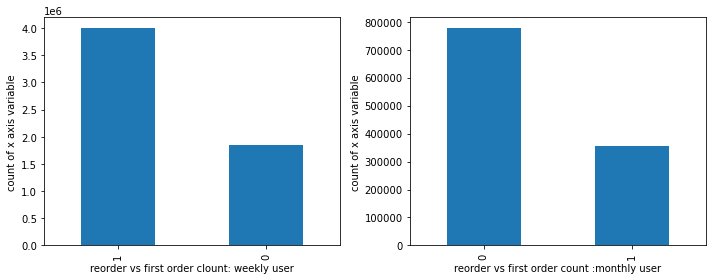

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
master_prior_weekly.reordered.value_counts().head(20).plot(kind='bar')
plt.xlabel('reorder vs first order clount: weekly user')
plt.ylabel('count of x axis variable')
plt.subplot(1,2,2)
master_prior_monthly.reordered.value_counts().head(20).plot(kind='bar')
plt.xlabel('reorder vs first order count :monthly user')
plt.ylabel('count of x axis variable')
plt.tight_layout()

<ul>
<li>X_axis:0:first time orders 1:reorders  y_axis:Count of x_axis variable</li>
<li>From weekly user graph we see that reorders are as twice as first time orders</li>
<li>From monthly user graph we see that fist time orders are more than reorders</li>
<li>May be montly buyers tend to buy new products rather than reordering them </li>
<li>So days since prior order variable can capture the information whether a user is a monthly buyer or weekly buyer</li>
</ul>

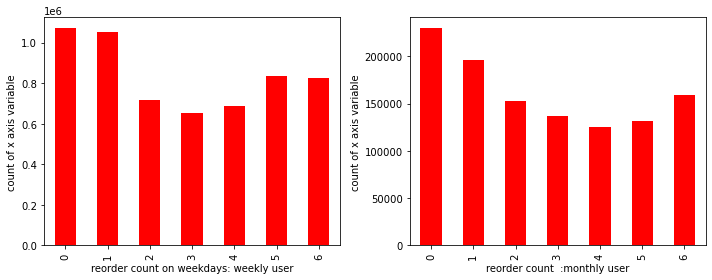

In [24]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
master_prior_weekly.order_dow.value_counts(sort=False).plot(kind='bar',colormap='hsv')
plt.xlabel('reorder count on weekdays: weekly user')
plt.ylabel('count of x axis variable')

plt.subplot(1,2,2)
master_prior_monthly.order_dow.value_counts(sort=False).plot(kind='bar',colormap='hsv')
plt.xlabel('reorder count  :monthly user')
plt.ylabel('count of x axis variable')
plt.tight_layout()

Reorder count of weekdays on weekdays/monthly data is not a very useful feature as both the graphs almost look similar

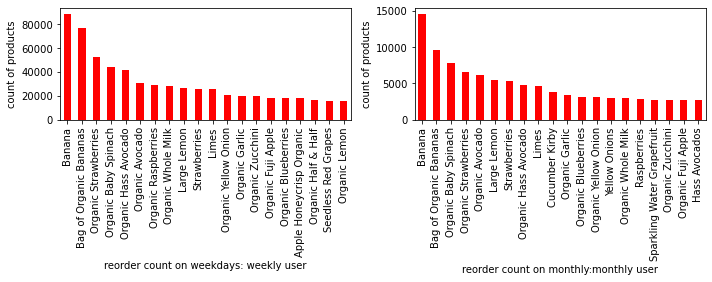

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
master_prior_weekly.product_name.value_counts(sort=True).head(20).plot(kind='bar',colormap='hsv')
plt.xlabel('reorder count on weekdays: weekly user')
plt.ylabel('count of products')

plt.subplot(1,2,2)
master_prior_monthly.product_name.value_counts(sort=True).head(20).plot(kind='bar',colormap='hsv')
plt.xlabel('reorder count on monthly:monthly user')
plt.ylabel('count of products')
plt.tight_layout()

Reorder count of productls on weekly and monthly buyers data is not a very useful feature as they look very similar

#### Reorder ratio and reorder probability

In [ ]:
truthvalues2=(master_prior_weekly['order_number']==2) & (master_prior_weekly['reordered']==1)
truthvalues1=(master_prior_weekly['order_number']==1)

In [30]:
data_order_1 = master_prior_weekly[truthvalues1][['user_id','product_id','product_name']]
data_order_2=master_prior_weekly[truthvalues2][['user_id','product_id','product_name']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])
dataframe_whole=pd.DataFrame(data_order_1.groupby(['product_name'])['product_name'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['product_name'])['product_name'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
weekly_product_reorder=dataframe_intersect/dataframe_whole.loc[intersec12]

In [31]:
truthvalues2=(master_prior_monthly['order_number']==2) & (master_prior_monthly['reordered']==1)
truthvalues1=(master_prior_monthly['order_number']==1)

In [32]:
data_order_1 = master_prior_monthly[truthvalues1][['user_id','product_id','product_name']]
data_order_2=master_prior_monthly[truthvalues2][['user_id','product_id','product_name']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])
dataframe_whole=pd.DataFrame(data_order_1.groupby(['product_name'])['product_name'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['product_name'])['product_name'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
monthly_product_reorder=dataframe_intersect/dataframe_whole.loc[intersec12]

reoder_ratio_monthly=master_prior_monthly.groupby(['product_name'])['reordered'].aggregate('mean').reset_index().set_index('product_name').loc[comman_index]
reoder_ratio_weekly=master_prior_weekly.groupby(['product_name'])['reordered'].aggregate('mean').reset_index().set_index('product_name').loc[comman_index]

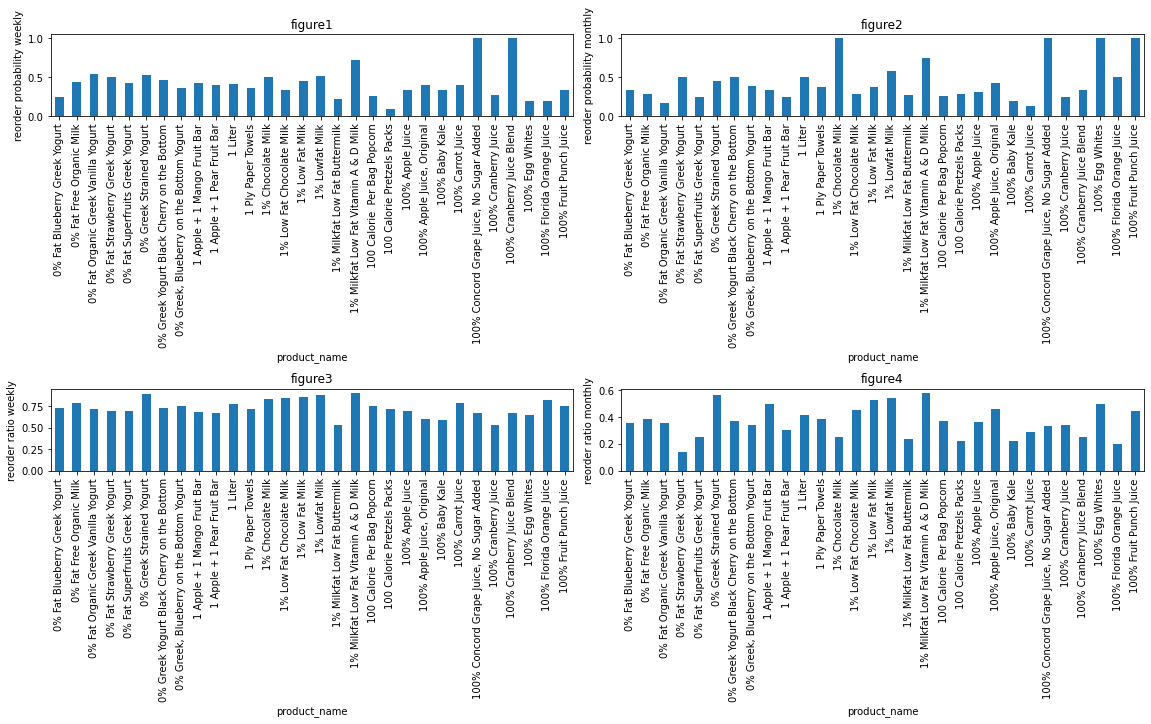

In [76]:
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.title('figure1')
weekly_product_reorder.loc[comman_index]['product_name'].head(30).plot(kind ='bar')
plt.ylabel('reorder probability weekly')

plt.subplot(2,2,2)
plt.title('figure2')
monthly_product_reorder.loc[comman_index]['product_name'].head(30).plot(kind ='bar')
plt.ylabel('reorder probability monthly')

plt.subplot(2,2,3)
plt.title('figure3')
reoder_ratio_weekly['reordered'].head(30).plot(kind='bar')
plt.ylabel('reorder ratio weekly')

plt.subplot(2,2,4)
plt.title('figure4')
reoder_ratio_monthly['reordered'].head(30).plot(kind='bar')
plt.ylabel('reorder ratio monthly')

plt.tight_layout()

<ul>
<li>figure1 and figure2 are reorder probability vs product of weekly and monthly data respectively</li>
<li>We can see there is lot of variation in reorder probability of these two data</li>
<li>figure3 and figure4 are reorder ratio vs product of weekly and monthly buyers data respectively</li>
<li>We can see there is lot of variation in reorder ratio of these data</li>
<li>May be product with high reorder probability and high reorder ration highly likely to be reordered</li>
</ul>

### Add_to_cart probability of reorder

In [15]:
truthvalues2=(master_prior['order_number']==2) & (master_prior['reordered']==1)
truthvalues1=(master_prior['order_number']==1)

In [16]:
data_order_1 = master_prior[truthvalues1][['user_id','product_id','add_to_cart_order']]
data_order_2=master_prior[truthvalues2][['user_id','product_id','add_to_cart_order']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])
dataframe_whole=pd.DataFrame(data_order_1.groupby(['add_to_cart_order'])['add_to_cart_order'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['add_to_cart_order'])['add_to_cart_order'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
add_cart_reorder_probability12=dataframe_intersect/dataframe_whole.loc[intersec12]

In [31]:
final_probability = (add_cart_reorder_probability12.loc[a12345]+add_cart_reorder_probability23.loc[a12345]+add_cart_reorder_probability34+add_cart_reorder_probability45.loc[a12345])/4

In [34]:
final_probability=final_probability.fillna(np.mean(final_probability))
locations_not_present = np.delete(np.arange(1,146,1),final_probability.index-1)
new_data=pd.DataFrame(np.full(len(locations_not_present),0.2),index=locations_not_present,columns=['add_to_cart_order'])
new_data.index.name='add_to_cart_order'
add_cart_reorder_prob=pd.concat([final_probability,new_data]).sort_index()
add_cart_reorder_prob.rename(columns={'add_to_cart_order':'probability'}).to_csv('add_cart_reorder_prob.csv')

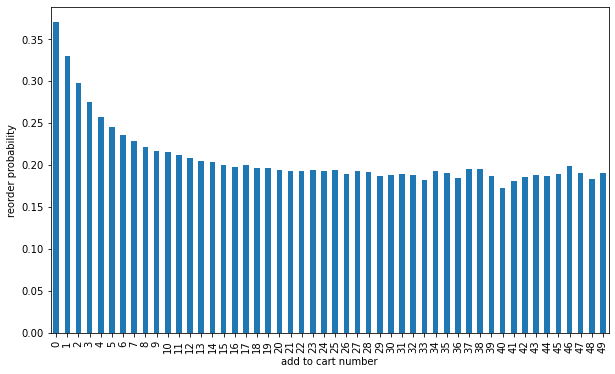

In [78]:
plt.figure(figsize=(10,6))
pd.read_csv('add_cart_reorder_prob.csv')['probability'].head(50).plot(kind='bar')
plt.xlabel('add to cart number')
plt.ylabel('reorder probability')
plt.show()

<ul>
<li>x_axis:add_to_cart number y_axis:reorder probability</li>
<li>We can see that when add to cart number is less ,probability is high. This is how add to cart order directly affects reorder variable </li>
</ul>

# Order dow reorder probability

In [3]:
truthvalues2=(master_prior['order_number']==2) & (master_prior['reordered']==1)
truthvalues1=(master_prior['order_number']==1)

In [6]:
data_order_1 = master_prior[truthvalues1][['user_id','product_id','order_dow']]
data_order_2=master_prior[truthvalues2][['user_id','product_id','order_dow']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])
dataframe_whole=pd.DataFrame(data_order_1.groupby(['order_dow'])['order_dow'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['order_dow'])['order_dow'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
order_dow_probability12=dataframe_intersect/dataframe_whole.loc[intersec12]

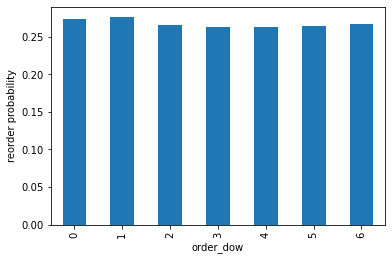

In [7]:
order_dow_probability12.head(25).plot(kind='bar',legend=False)
plt.ylabel('reorder probability')
plt.show()

Order_dow reorder probability is not a helpful feature for predicting reordering as it looks constan on all days of the week.

#### productwise reorder probability

In [103]:
truthvalues1=(master_prior['order_number']==1)
truthvalues2=(master_prior['order_number']==2) & (master_prior['reordered']==1)

In [104]:
data_order_1 = master_prior[truthvalues1][['user_id','product_id','product_name']]
data_order_2=master_prior[truthvalues2][['user_id','product_id','product_name']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])

In [105]:
dataframe_whole=pd.DataFrame(data_order_1.groupby(['product_name'])['product_id'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['product_name'])['product_id'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
product_reorder_probability12=dataframe_intersect/dataframe_whole.loc[intersec12]

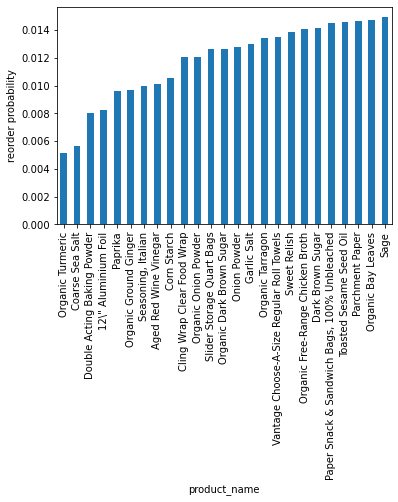

In [85]:
product_reorder_probability12.sort_values(by='product_id',ascending=True).head(25).plot(kind='bar',legend=False)
plt.ylabel('reorder probability')
plt.show()

<ul>
<li>x_axis:product    &nbsp;&nbsp;  y_axis:reorder probability</li>
<li>We can see that for certain products ,probability of reorder is high. This is how individual product types affect the reorder . Products with higher reorder probability tend to be reordered often </li>
</ul>

#### aislwise order reroder probability

In [106]:
data_order_1 = master_prior[truthvalues1][['user_id','product_id','aisle']]
data_order_2=master_prior[truthvalues2][['user_id','product_id','aisle']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])
dataframe_whole=pd.DataFrame(data_order_1.groupby(['aisle'])['aisle'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['aisle'])['aisle'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
product_reorder_probability12=dataframe_intersect/dataframe_whole.loc[intersec12]

<Figure size 1080x432 with 0 Axes>

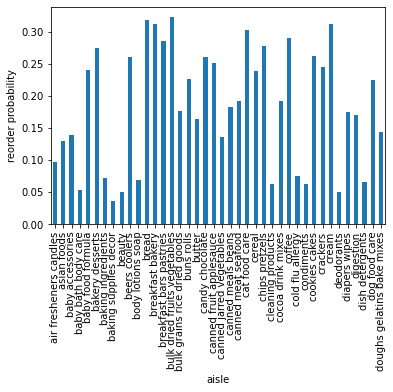

In [109]:
plt.figure(figsize=(15,6))
product_reorder_probability12.head(40).plot(kind='bar',legend=False)
plt.xlabel('aisle')
plt.ylabel('reorder probability')
plt.show()

<ul>
<li>x_axis : aisle  &nbsp; &nbsp;  y_axis : reorder probability</li>
<li>We can see that for certain aisles ,probability of reorder is high. This is how individual aisle types affect the reorder . aisles with higher reorder probability tend to be reordered often </li>
</ul>

#### days since prior reroder probability

In [110]:
truthvalues1=(master_prior['order_number']==2)
truthvalues2=(master_prior['order_number']==3) & (master_prior['reordered']==1)

In [111]:
data_order_1 = master_prior.dropna(axis=0)[truthvalues1][['user_id','product_id','days_since_prior_order']]
data_order_2=master_prior.dropna(axis=0)[truthvalues2][['user_id','product_id','days_since_prior_order']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])
dataframe_whole=pd.DataFrame(data_order_1.groupby(['days_since_prior_order'])['days_since_prior_order'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['days_since_prior_order'])['days_since_prior_order'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
product_reorder_probability12=dataframe_intersect/dataframe_whole.loc[intersec12]

<Figure size 1080x432 with 0 Axes>

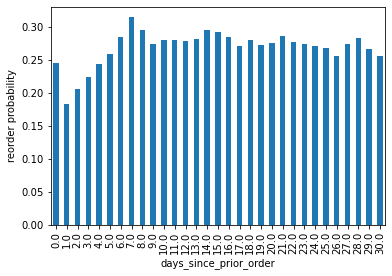

In [114]:
plt.figure(figsize=(15,6))
product_reorder_probability12.plot(kind='bar',legend=False)
plt.ylabel('reorder probability')
plt.show()

<ul>
<li>x_axis:days since prior order   &nbsp;&nbsp;  y_axis:reorder probability</li>
<li>We can see that for certain products ,probability of reorder is high. This is how days since prior order affect the reorders. For some time gap,there is higher reorder probability </li>
</ul>

#### departmentwise reorder probability

In [115]:
truthvalues1=(master_prior['order_number']==1)
truthvalues2=(master_prior['order_number']==2) & (master_prior['reordered']==1)

In [116]:
data_order_1 = master_prior[truthvalues1][['user_id','product_id','department']]
data_order_2=master_prior[truthvalues2][['user_id','product_id','department']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])
dataframe_whole=pd.DataFrame(data_order_1.groupby(['department'])['department'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['department'])['department'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
product_reorder_probability12=dataframe_intersect/dataframe_whole.loc[intersec12]

<Figure size 1080x432 with 0 Axes>

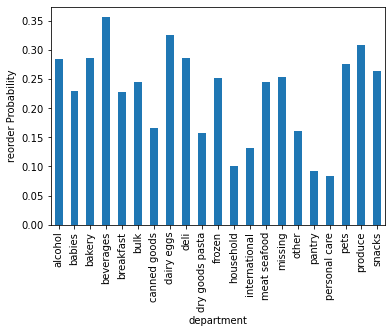

In [119]:
plt.figure(figsize=(15,6))
product_reorder_probability12.plot(kind='bar',legend=False)
plt.ylabel('reorder Probability')
plt.show()

<ul>
<li>x_axis:department &nbsp;&nbsp;  y_axis:reorder probability</li>
<li>We can see that for some departments ,probability of reorder is high. This is how individual departments types affect the reorder. Departments with higher reorder probability tend to be reordered often </li>
<li>This feature when fed to a machine learning model like xgboost then interact with other features designed previously and make an effort predict product reorder probability  </li>
</ul>

#### Weekend vs previours two days and next two days  data analysis

In [120]:
truth1=master_prior['order_dow']==0
truth2=master_prior['order_dow']==6

In [121]:
truth45_temp1=master_prior['order_dow']==4
truth45_temp2=master_prior['order_dow']==5

In [122]:
truth12_temp1=master_prior['order_dow']==1
truth12_temp2=master_prior['order_dow']==2

In [123]:
data_weekend=master_prior[truth1 | truth2]

In [124]:
data_week45=master_prior[truth45_temp1|truth45_temp2]
data_week12=master_prior[truth12_temp2|truth12_temp1]

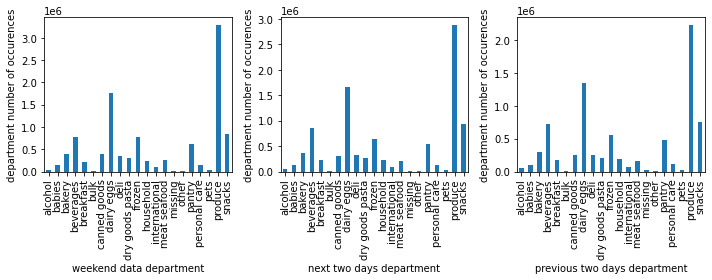

In [125]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
data_weekend.groupby(['department'])['reordered'].count().plot(kind='bar')
plt.xlabel('weekend data department')
plt.ylabel('department number of occurences')
plt.subplot(1,3,2)
data_week12.groupby(['department'])['reordered'].count().plot(kind='bar')
plt.xlabel('next two days department')
plt.ylabel('department number of occurences')
plt.subplot(1,3,3)

data_week45.groupby(['department'])['reordered'].count().plot(kind='bar')
plt.xlabel('previous two days department')
plt.ylabel('department number of occurences')
plt.tight_layout()

<ul>
<li>x_axis:departments and y_axis: total departmentment week</li>
<li>first graph is department counts of products only bought in weekends;Similarly second graph for Monday and Tuesday,other graph on thursday and Friday</li>
<li>Vegetables and fruits are ordered more on weekends and first two days of the week rather than on thursday and friday </li>
<li>As all graphs are looking similar departmentwise count may not be very helpful feature in predicting reorder probability </li>
</ul>

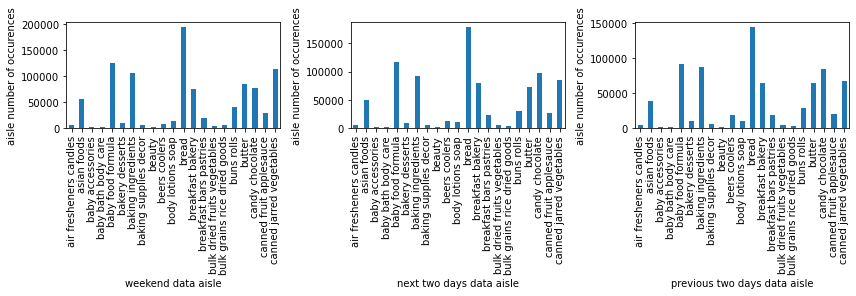

In [126]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
data_weekend.groupby(['aisle'])['reordered'].count().head(21).plot(kind='bar')
plt.xlabel('weekend data aisle')
plt.ylabel('aisle number of occurences')
plt.subplot(1,3,2)
data_week12.groupby(['aisle'])['reordered'].count().head(21).plot(kind='bar')
plt.xlabel('next two days data aisle')
plt.ylabel('aisle number of occurences')
plt.subplot(1,3,3)
data_week45.groupby(['aisle'])['reordered'].count().head(21).plot(kind='bar')
plt.xlabel('previous two days data aisle')
plt.ylabel('aisle number of occurences')
plt.tight_layout()

<ul>
<li>x_axis:departments and y_axis: total departmentment week</li>
<li>first graph is department counts of products only bought in weekends;Similarly second graph for Monday and Tuesday,other graph on thursday and Friday</li>
<li>Vegetables and fruits are ordered more on weekends and first two days of the week rather than on thursday and friday </li>
<li>As all graphs are looking similar departmentwise count may not be very helpful feature in predicting reorder probability </li>
</ul>

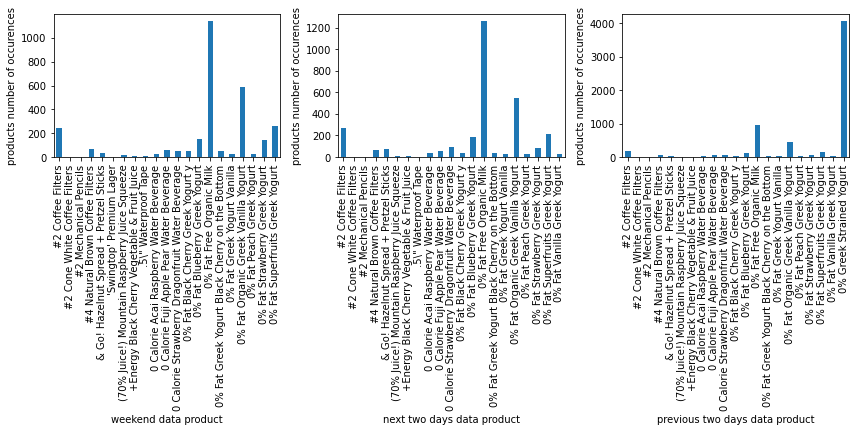

In [130]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
data_weekend.groupby(['product_name'])['reordered'].count().head(21).plot(kind='bar')
plt.xlabel('weekend data product')
plt.ylabel('products number of occurences')
plt.subplot(1,3,2)
data_week12.groupby(['product_name'])['reordered'].count().head(21).plot(kind='bar')
plt.xlabel('next two days data product')
plt.ylabel('products number of occurences')
plt.subplot(1,3,3)
data_week45.groupby(['product_name'])['reordered'].count().head(21).plot(kind='bar')
plt.xlabel('previous two days data product')
plt.ylabel('products number of occurences')
plt.tight_layout()

<ul>
<li>x_axis:departments and y_axis: total departmentment week</li>
<li>first graph is department counts of products only bought in weekends;Similarly second graph for Monday and Tuesday,other graph on thursday and Friday</li>
<li>Vegetables and fruits are ordered more on weekends and first two days of the week rather than on thursday and friday </li>
<li>As all graphs are looking similar departmentwise count may not be very helpful feature in predicting reorder probability </li>
</ul>

Weekend end

#### departments that are sold more in each hour of the day

In [111]:
hour_depart_count=master_prior.groupby(["order_hour_of_day", "department"])['department_id'].count()
temp=master_prior.groupby(["order_hour_of_day", "department"])['department_id'].count().min(level=0)
k=hour_depart_count.reset_index()
k[k.department_id.isin(temp.values)].rename(columns={'department_id':'department_count'})

,order_hour_of_day,department,department_count
5,0,bulk,238
26,1,bulk,117
47,2,bulk,66
68,3,bulk,49
89,4,bulk,47
110,5,bulk,78
141,6,other,324
152,7,bulk,908
183,8,other,1818
204,9,other,2643


In [112]:
hour_depart_count=master_prior.groupby(["order_hour_of_day", "department"])['department_id'].count()
temp=master_prior.groupby(["order_hour_of_day", "department"])['department_id'].count().max(level=0)
k=hour_depart_count.reset_index()
k[k.department_id.isin(temp.values)].rename(columns={'department_id':'department_count'})

,order_hour_of_day,department,department_count
19,0,produce,68393
40,1,produce,35050
61,2,produce,20016
82,3,produce,14357
103,4,produce,15341
124,5,produce,26896
145,6,produce,87204
166,7,produce,268657
187,8,produce,510782
208,9,produce,714001


At each hour produce is the most sold out department and bulk is the department which is ordered less

#### Order hour of day reorder probability

In [131]:
truthvalues2=(master_prior['order_number']==2) & (master_prior['reordered']==1)
truthvalues1=(master_prior['order_number']==1)
data_order_1 = master_prior[truthvalues1][['user_id','product_id','order_hour_of_day']]
data_order_2=master_prior[truthvalues2][['user_id','product_id','order_hour_of_day']]
data_order_12 = pd.merge(data_order_1,data_order_2[['user_id','product_id']],how='inner',on=['user_id','product_id'])
dataframe_whole=pd.DataFrame(data_order_1.groupby(['order_hour_of_day'])['order_hour_of_day'].count())
dataframe_intersect=pd.DataFrame(data_order_12.groupby(['order_hour_of_day'])['order_hour_of_day'].count())
intersec12=np.intersect1d(dataframe_intersect.index,dataframe_whole.index)
add_cart_reorder_probability12=dataframe_intersect/dataframe_whole.loc[intersec12]

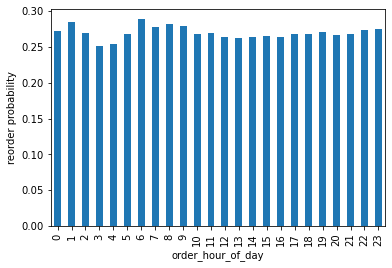

In [136]:
add_cart_reorder_probability12['order_hour_of_day'].plot(kind='bar',legend=False)
plt.ylabel('reorder probability')
plt.show()

<ul>
<li>x_axis:order hour of day &nbsp;&nbsp;  y_axis:reorder probability</li>
<li>order hour of day reorder probability w.r.t to all products does not seem to be a very useful feature as it is not having much variation  </li>
</ul>

#### <font color='red'>order day of the week</font>

In [5]:
temp1=master_prior[['order_dow','reordered','order_hour_of_day','days_since_prior_order']]
temp2=master_prior[master_prior['product_name']=='Chipotle Beef & Pork Realstick'][['order_dow','reordered','order_hour_of_day','days_since_prior_order']]


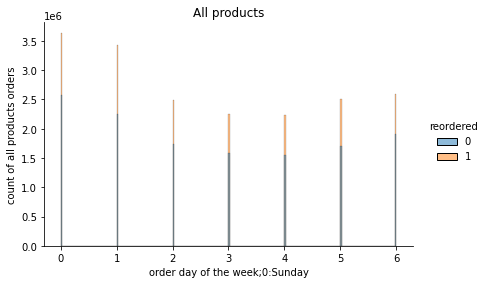

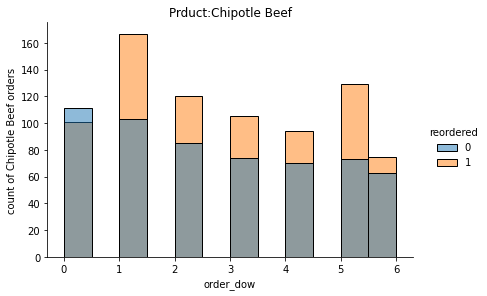

In [11]:
sns.displot(temp1,x='order_dow',hue='reordered',aspect=1.5,height=4)
plt.title('All products')
plt.ylabel('count of all products orders')
plt.xlabel('order day of the week;0:Sunday')
plt.show()

sns.displot(temp2,x='order_dow',hue='reordered',aspect=1.5,height=4)
plt.title('Prduct:Chipotle Beef')
plt.ylabel('count of Chipotle Beef orders')
plt.show()

<ul>
  <li >In the above graph x_axis:day of the week is plotted against y_axis:count of products ordered</li>
  <li>blue legend indicates they are first time orders and orange indicates reordered product count</li>
  <li>From the above graph we can observe that on Sundays and Mondays more products are ordered</li>
  <li>Each day first time orders are lesser than reordered products</li>
  <li>We do not get much information about reordered rate from first graph</li>
   <li>In the second graph above I plot the same thing on one product,we can see that reordered products are more on Monday.
    So this infomation may vary on different products and may be helpful in our analysis</li>
</ul>

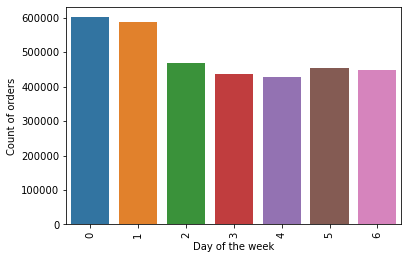

In [16]:
sns.countplot(x="order_dow", data=orders)
plt.ylabel('Count of orders')
plt.xlabel('Day of the week')
plt.xticks(rotation='vertical')
plt.show()

Above graph shows total count of orders on each day of the week. 0:Sunday. Same analysis can be done as the previous graphs for day of the week.

#### <font color='red'>order hour of the day</font>

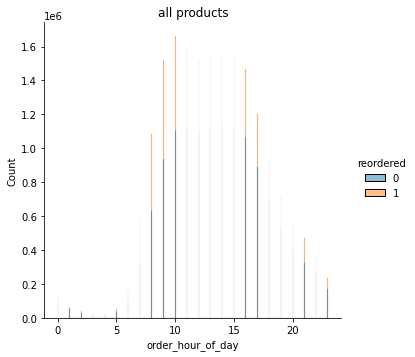

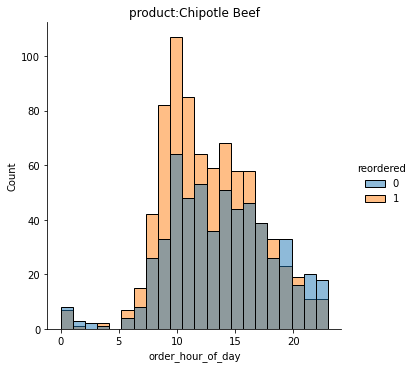

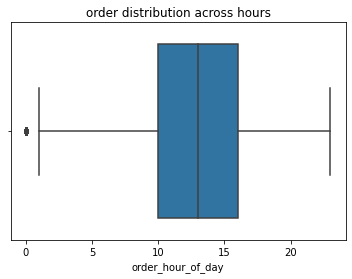

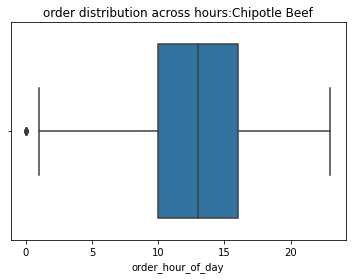

In [200]:
sns.displot(temp1,x='order_hour_of_day',hue='reordered')
plt.title('figure1:all products')
plt.show()


sns.displot(temp2,x='order_hour_of_day',hue='reordered')
plt.title('figure2:product:Chipotle Beef')
plt.show()

sns.boxplot(temp1.dropna(axis=0)['order_hour_of_day'])
plt.title('figure3:order distribution across hours:all products')
plt.show()

sns.boxplot(temp2.dropna(axis=0)['order_hour_of_day'])
plt.title('figure4:order distribution across hours:Chipotle Beef')

plt.show()

<ul>
  <li >In the above graphs(figure1,figure2) x_axis:order hour of the day is plotted against y_axis:count of products ordered</li>
  <li>blue legend indicates they are first time orders and orange indicates reordered product count</li>
  <li>From the above graph we can observe that between 10 to 15 hours more products are ordered</li>
  <li>Each hour first time orders are lesser than reordered products</li>
  <li>figure2:same as figure1 but plotted for single product,here at 10 am order rate is more,so when we consider all products order rate is more between 10 to 15 hours and when we consider a single product reorder rate,it is more at a perticular time. </li>
  <li>figure3 and figure4 are boxplots which indicate between 10 to 15 hours 50% orders are placed</li>
    <li>As products like icecreams are usually ordered in the evening, we may get good variation in the reordered rate with time when it comes to single user and product </li>
</ul>

<Figure size 576x432 with 0 Axes>

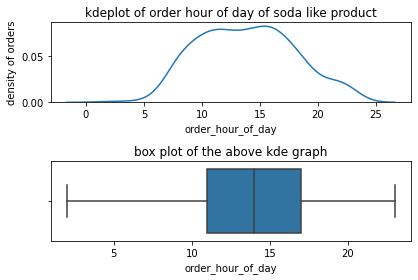

In [21]:
k=master_prior['product_name'].str.contains('cereal',regex=False)
plt.figure(figsize=(8,6))
fig,ax=plt.subplots(1,2)
plt.subplot(2,1,1)
plt.title('kdeplot of order hour of day of soda like product')
sns.kdeplot(master_prior[k]['order_hour_of_day'])
plt.ylabel('density of orders')
plt.subplot(2,1,2)
plt.title('box plot of the above kde graph')
sns.boxplot(master_prior[k]['order_hour_of_day'])
plt.tight_layout()


<ul>
<li>In the above graph first subplot is kdeplot of x_axis=order_hour_of_the_day.Y_axis indicates order count distribution of a single product(Here I have chosen 'Soda' )</li>
<li>As we can see in the above kdeplot graph for a soda like product order rate is peak after 3 pm and from box plot we can conclude that 50% orderes are placed between 11 to 17 hours.Hence there is higher reorder chance between this time gap</li>
</ul>

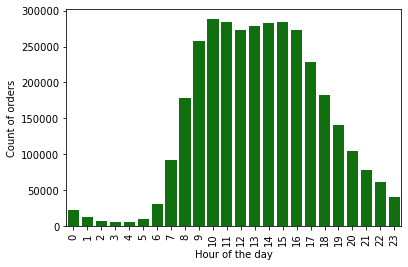

In [22]:
sns.countplot(x="order_hour_of_day", data=orders,color='green')
plt.ylabel('Count of orders')
plt.xlabel('Hour of the day')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>x_axis:hour of the day order is plotted against y_axis:count of orders irrespective of first time orders or reorders</li>
<li>orders are more between 9 to 15 hours.</li>
<li>As orders more between this time gap, it may be helpful to predict at what time user may reorder product. Because a user may reorder in his free time or when he needs a product </li>
</ul>

#### <font color='red'>Days since prior order</font>

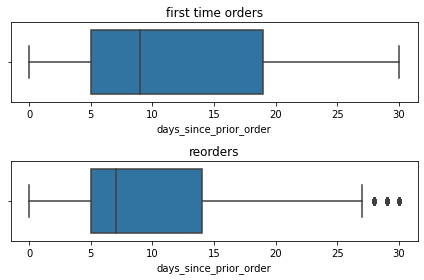

In [15]:
plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.title('first time orders')
sns.boxplot(master_prior.dropna(axis=0)[master_prior['reordered']==0]['days_since_prior_order'])
plt.subplot(2,1,2)
plt.title('reorders')
sns.boxplot(master_prior.dropna(axis=0)[master_prior['reordered']==1]['days_since_prior_order'])
plt.tight_layout()

<ul>
  <li >Above two graphs are box_plots of days_since_prior_order variable</li>
  <li>figure1:box plot of days_since_prior_order of first time orders </li>
  <li>figure2:box plot of days_since_prior_order of reorders;</li>
  <li>figure1: days since prior order is from 5 to 19 days</li>
  <li>figure2: days since prior order is from 5 to 14 days</li>
  <li>This variation may be because of reordered products are ordered within 14 days usually</li>
   <li>Between 5 to 14 hours product may be reordered with more probability</li>
</ul>

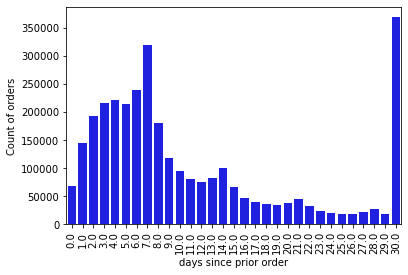

In [14]:
sns.countplot(x="days_since_prior_order", data=orders,color='blue')
plt.ylabel('Count of orders')
plt.xlabel('days since prior order')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>x_axis:days since prior order is plotted against y_axis:count of orders</li>
<li>orders are more on 7days time gap and 30 days time gap. It may be because there may be weekly and monthly reorder pattern.Also from 3 days time gap to 8 days time gap more products are ordered .</li>
<li>As this variable is showing good variation across different time gaps ,it would be helpful in predicting reorder products</li>
</ul>

### Bi-variate analysis

#### <font color='red'>reorder_ratio:order_day_of_week</font>

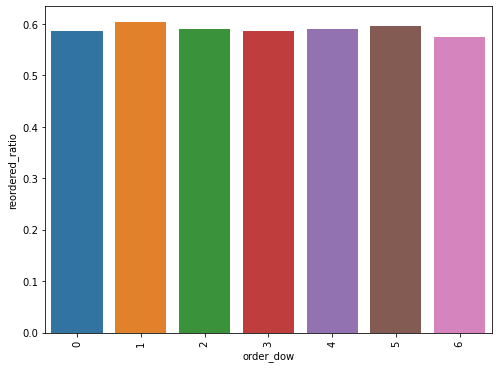

In [154]:
plt.figure(figsize=(8,6))
dow_reorder_ratio=master_prior.groupby(['order_dow'])['reordered'].aggregate('mean').reset_index().sort_values(by=['order_dow'],ascending=True)
dow_reorder_ratio=dow_reorder_ratio.rename(columns={'reordered':'reordered_ratio'}).head(40)
sns.barplot(dow_reorder_ratio.order_dow,dow_reorder_ratio.reordered_ratio)
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>x_axis:order day of the week is plotted against y_axis:reorder_ratio</li>
<li>It shows that reorder ratio is almost equal on all days</li>
<li>Hence total reorder ratio with respect to order day of the week may not be a helpful feature</li>
<li>Here total reorder ratio means reorder ratio with respect to all the products</li>
<li>But still I want to consider this feature as there may be certain products which are ordered during weekends or on some perticular day etc.</li>
</ul>

#### <font color='red'>Reorder_ratio with respect to order hour of day</font>

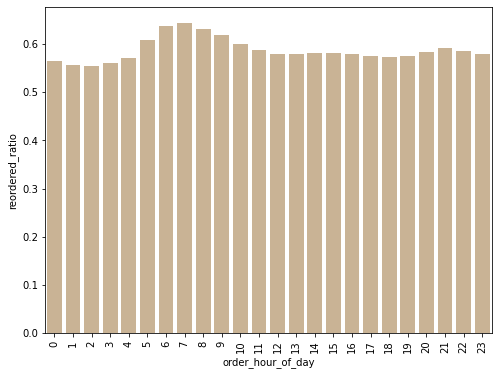

In [23]:
plt.figure(figsize=(8,6))
hour_reorder_ratio=master_prior.groupby(['order_hour_of_day'])['reordered'].aggregate('mean').reset_index().sort_values(by=['order_hour_of_day'],ascending=True)
hour_reorder_ratio=hour_reorder_ratio.rename(columns={'reordered':'reordered_ratio'}).head(40)
sns.barplot(hour_reorder_ratio.order_hour_of_day,hour_reorder_ratio.reordered_ratio,color='tan')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>x_axis:order hour of the day  is plotted against y_axis:reorder ratio of all products </li>
<li>Reorder ratio is showing promising variation across hours</li>
<li>For example at 6 and 7 am hours there is higher reorder ratio ,indicating there may be products which are reordered during this time like breakfast cereals etc...</li>
<li>So this is a useful feature to predict a product would be reorodered or not</li>
</ul>

#### <font color='red'>Reorder_ratio:days_since_prior_order</font>

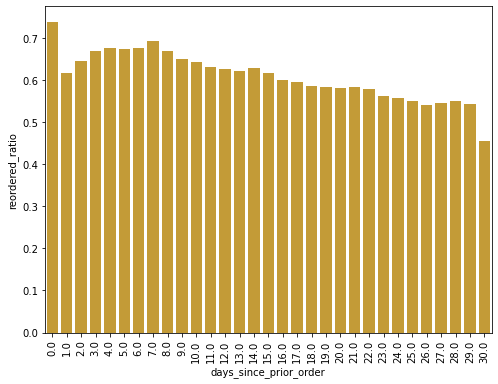

In [24]:
plt.figure(figsize=(8,6))
days_reorder_ratio=master_prior.groupby(['days_since_prior_order'])['reordered'].aggregate('mean').reset_index().sort_values(by=['days_since_prior_order'],ascending=True)
days_reorder_ratio=days_reorder_ratio.rename(columns={'reordered':'reordered_ratio'}).head(40)
sns.barplot(days_reorder_ratio.days_since_prior_order,days_reorder_ratio.reordered_ratio,color='goldenrod')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>Here x_axis:days_since_prior_order is plotted against reordered ratio</li>
<li>Above graph shows reorder ratio is high when days gap is around 6 to 8 days</li>
<li>When number of days go beyond 17 days reorder rate will decrease.</li>
<li>As there is good variation of reorder ratio across days it is a promising feature</li>
</ul>

#### <font color='red'>Count of user's maximum order number</font>

Text(0.5, 0, 'maximum order number')

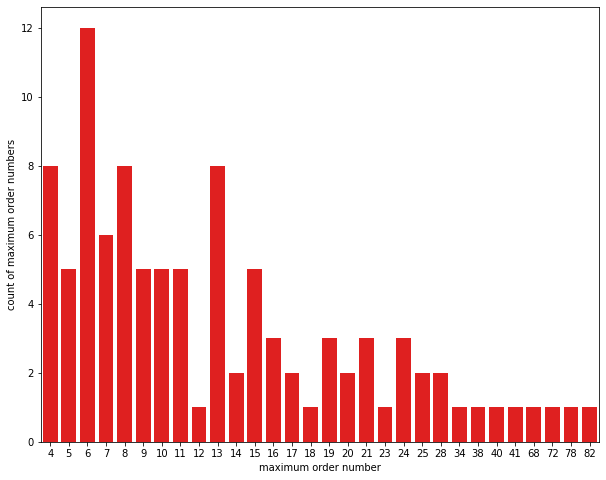

In [12]:
plt.figure(figsize=(10,8))
order_count = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
sns.countplot(order_count['order_number'].head(100),color='red')
plt.ylabel('count of maximum order numbers')
plt.xlabel('maximum order number')


<ul>
<li>X_axis:maximum order numbers of users , Y_axis:count of maximum order numbers</li>
<li>For example if a user has ordered total 4 times , it measures  how many users ordered maximum these many times </li>
<li>This feature is helpful as it measures the buying tendency of users</li>
<li>A user more likely to buy products,more likely reorders also</li>
</ul>

#### <font color='red'>Mean add to cart order with respect to each product</font>

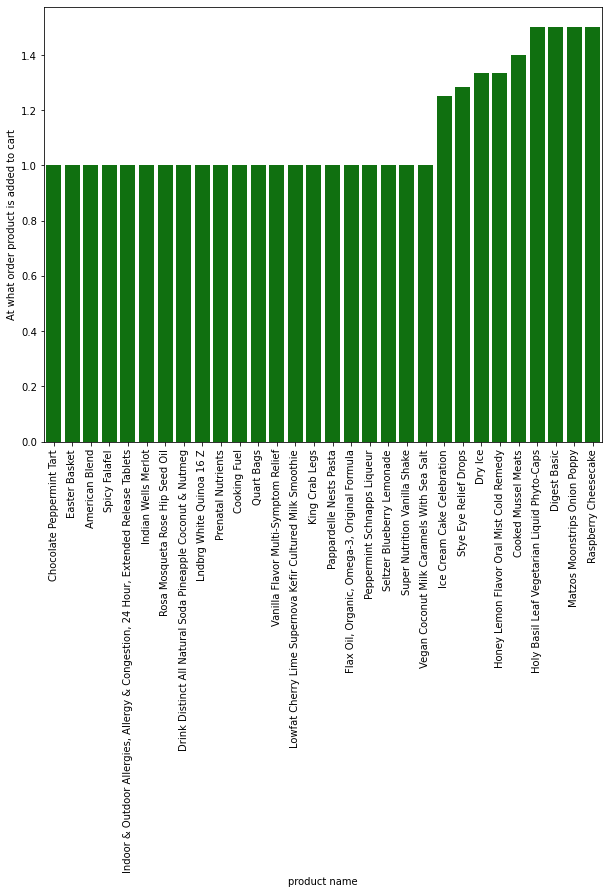

In [142]:
plt.figure(figsize=(10,8))

add_to_cart = master_prior.groupby("product_name")["add_to_cart_order"].aggregate(np.mean).reset_index().sort_values(by=['add_to_cart_order'],ascending=True)
add_to_cart=add_to_cart.rename(columns={'add_to_cart_order':'mean_add_to_cart_order'}).head(30)
sns.barplot(add_to_cart.product_name,add_to_cart.mean_add_to_cart_order,color='green')
plt.ylabel('At what order product is added to cart')
plt.xlabel('product name')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>Here product name is plotted against at what sequence product is added to cart in a perticular order</li>
<li>Here I have taken mean add to cart order</li>
<li>Products which are added at the begining when user starts adding product can be important</li>
<li>User may think of the products he likes frequently at the begining when he starts adding products to cart</li>
 <li>Products which have less value likely to be reordered frequently</li>
</ul>

#### <font color='red'>Reorder ratio:add to cart order</font>

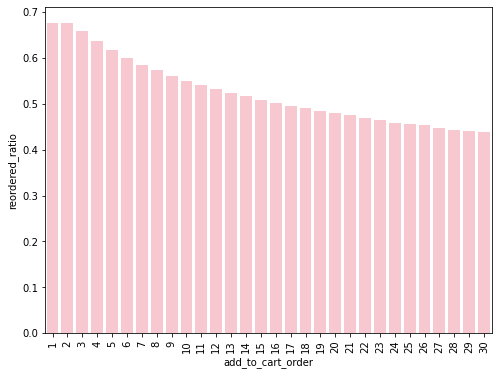

In [25]:
plt.figure(figsize=(8,6))
cart_level_reorder=master_prior.groupby(['add_to_cart_order'])['reordered'].aggregate('mean').reset_index().sort_values(by=['add_to_cart_order'],ascending=True)
cart_level_reorder=cart_level_reorder.rename(columns={'reordered':'reordered_ratio'}).head(30)
sns.barplot(cart_level_reorder.add_to_cart_order,cart_level_reorder.reordered_ratio,color='pink')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>Plotted x_axis:add_to_cart_order against reorder_ratio</li>
<li>In the previous plot we said add to cart order number plays an important role for predicting users preferance and reorder chance</li>
<li>This plot confirms add to cart number 1,2,3,4 etc have higher reorder ratio</li>
<li>As reorder ratio is showing good variation across add_to_cart number ,both of these featues are important</li>
</ul>

#### <font color='red'>Reorder ration with respect to perticular users</font>

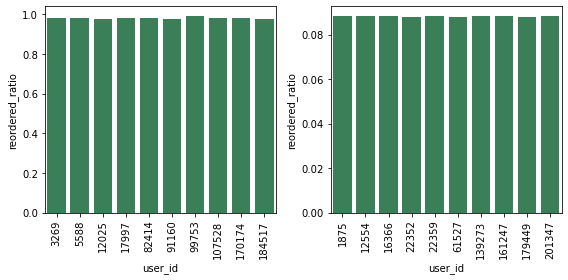

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
user_reorder_ratio=master_prior.groupby(['user_id'])['reordered'].aggregate('mean').reset_index().sort_values(by=['reordered'],ascending=False)
user_reorder_ratio=user_reorder_ratio.rename(columns={'reordered':'reordered_ratio'}).head(10)
sns.barplot(user_reorder_ratio.user_id,user_reorder_ratio.reordered_ratio,color='seagreen')
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
user_reorder_ratio=master_prior.groupby(['user_id'])['reordered'].aggregate('mean').reset_index().sort_values(by=['reordered'],ascending=False)
user_reorder_ratio=user_reorder_ratio.rename(columns={'reordered':'reordered_ratio'}).tail(10000).iloc[0:10]
sns.barplot(user_reorder_ratio.user_id,user_reorder_ratio.reordered_ratio,color='seagreen')
plt.xticks(rotation='vertical')
plt.tight_layout()



<ul>
<li>Plotted x_axis:User ID against y_axis:reorder ratio</li>
<li>plotted here is only for top 30 users who are ordered based on their reorder ratio in descending order</li>
<li>It shows some users have higher reorder tendency</li>
<li>So reorder ratio with respect user can be an importnant feature</li>
</ul>

### Product Id

## How much user orders?

#### <font color='red'>Count of number of times user buys the product</font>

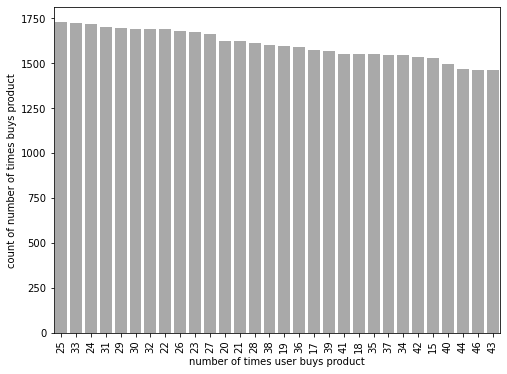

In [65]:
plt.figure(figsize=(8,6))
product_user_count = master_prior.groupby(['user_id'])['product_id'].count().sort_values(ascending=True)
product_user_buys_t=product_user_count.value_counts().head(40)
product_user_buys_t=pd.DataFrame(product_user_buys_t).rename(columns={'product_id': 'count_of_times_user_buys_product'}).head(30)
sns.barplot(product_user_buys_t.index,product_user_buys_t.values.reshape([1,30])[0],order=product_user_buys_t.index,color='darkgrey')
plt.xlabel('number of times user buys product')
plt.ylabel('count of number of times buys product')
plt.xticks(rotation='vertical')
plt.show()
#product_user_buys=pd.DataFrame(product_user_buys_t)
#product_user_buys['times_user_buys_product']=product_user_buys.index

<ul>
<li>Plotted x_axis:number of times user buys any product y_axis:count of x axis variable</li>
<li>plotted here is only for top 30 counts which are ordered based on their count in descending order</li>
<li>some users may get saturated after buying a product or any product</li>
<li>from this variable we can capture at what point of time user may stop ordering </li>
</ul>

#### <font color='red'>Product's total count</font>

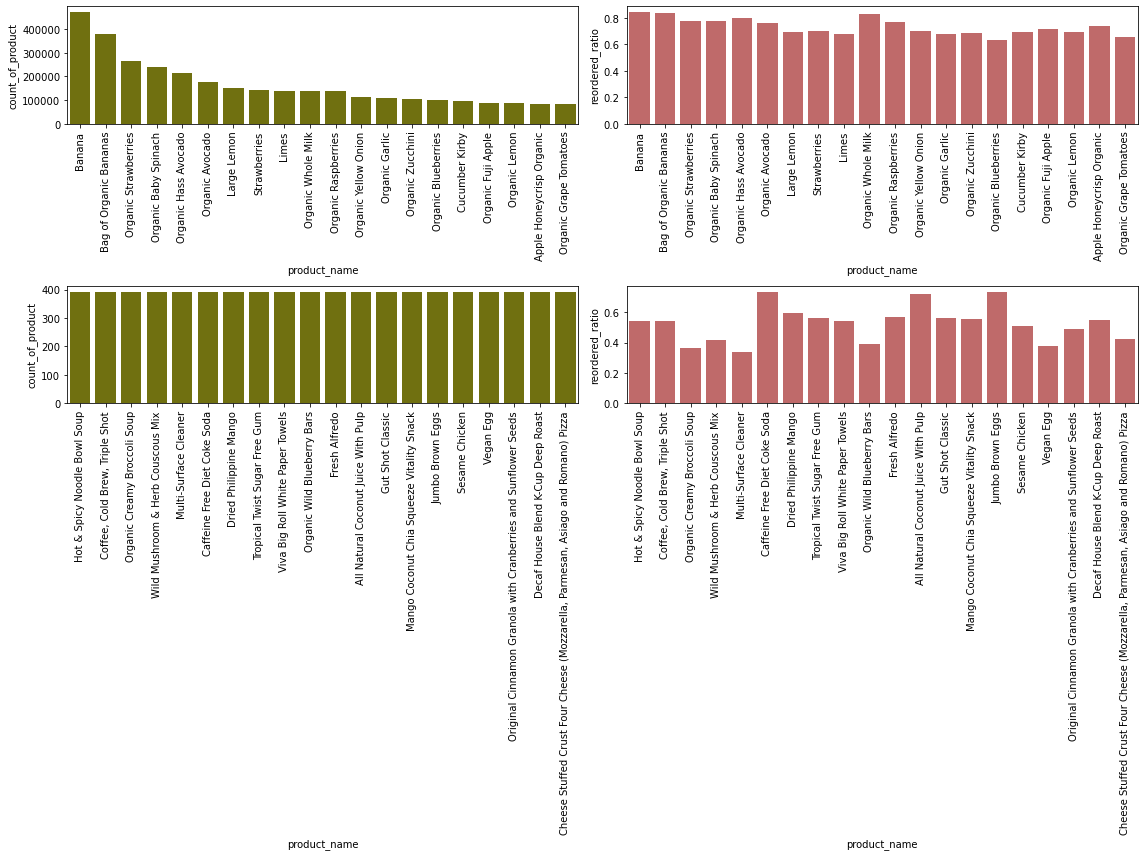

In [10]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
product_freq=master_prior.groupby(['product_name'])['product_id'].aggregate('count').reset_index().sort_values(by=['product_id'],ascending=False)
product_freq_mod=product_freq.rename(columns={'product_id':'count_of_product'}).head(20)
sns.barplot(product_freq_mod.product_name,product_freq_mod.count_of_product,color='olive')
plt.xticks(rotation='vertical')

plt.subplot(2,2,2)
product_reorder_ratio=master_prior.groupby(['product_name'])['reordered'].aggregate('mean').reset_index().sort_values(by=['reordered'],ascending=False)
product_reorder_ratio=product_reorder_ratio.loc[product_freq.index].rename(columns={'reordered':'reordered_ratio'}).head(20)
sns.barplot(product_reorder_ratio.product_name,product_reorder_ratio.reordered_ratio,color='indianred')
plt.xticks(rotation='vertical')

plt.subplot(2,2,3)
product_freq=master_prior.groupby(['product_name'])['product_id'].aggregate('count').reset_index().sort_values(by=['product_id'],ascending=False)
product_freq_mod=product_freq.rename(columns={'product_id':'count_of_product'}).tail(40000)[0:20]
sns.barplot(product_freq_mod.product_name,product_freq_mod.count_of_product,color='olive')
plt.xticks(rotation='vertical')

plt.subplot(2,2,4)
product_reorder_ratio=master_prior.groupby(['product_name'])['reordered'].aggregate('mean').reset_index().sort_values(by=['reordered'],ascending=False)
product_reorder_ratio=product_reorder_ratio.loc[product_freq.index].rename(columns={'reordered':'reordered_ratio'}).tail(40000)[0:20]
sns.barplot(product_reorder_ratio.product_name,product_reorder_ratio.reordered_ratio,color='indianred')
plt.xticks(rotation='vertical')
plt.tight_layout()




<ul>
<li>Here plotted x_axis:product_name against y_axis:count of occurance of each product</li>
<li>Product count can increase only if they are reordered more directly indicating reorder probabiliy</li>

</ul>

#### <font color='red'>Each product reorder ratio</font>

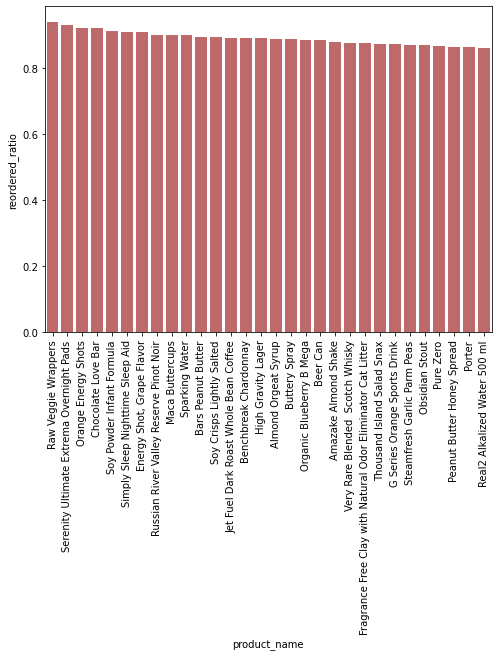

In [67]:
plt.figure(figsize=(8,6))
product_reorder_ratio=master_prior.groupby(['product_name'])['reordered'].aggregate('mean').reset_index().sort_values(by=['reordered'],ascending=False)
product_reorder_ratio=product_reorder_ratio.rename(columns={'reordered':'reordered_ratio'}).head(30)
sns.barplot(product_reorder_ratio.product_name,product_reorder_ratio.reordered_ratio,color='indianred')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>Here plotted x_axis:product name against y_axis:reorder ratio of the product</li>
<li>Products with higher reorder rate can be a direct indicator of a product will be reordered or not </li>
<li>So reorder ratio w.r.t product name is an important feature</li>
</ul>

#### <font color='red'>Pearson and Spearman's correlation coefficient</font>

In [79]:
product_count         = master_prior.dropna(axis=0).groupby(['product_name'])['product_id'].aggregate('count').reset_index()['product_id']
product_reorder_ratio = master_prior.dropna(axis=0).groupby(['product_name'])['reordered'].aggregate('mean').reset_index()['reordered']
mean_time_gap_product = master_prior.dropna(axis=0).groupby(['product_name'])['days_since_prior_order'].aggregate('mean').reset_index()['days_since_prior_order']

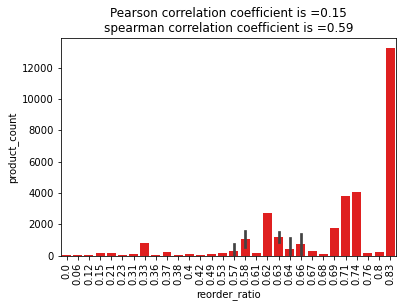

In [40]:
from scipy.stats import spearmanr
corr_coef=np.corrcoef(product_count, product_reorder_ratio)
sp_coeff=spearmanr(product_count, product_reorder_ratio)
#plt.scatter(product_reorder_ratio,product_count,color='red')
sns.barplot(product_reorder_ratio.head(40).round(decimals=2),product_count.head(40),color='red')
plt.title('Pearson correlation coefficient is ='+ str(np.round(corr_coef[0,1],2))+"\n"\
         "spearman correlation coefficient is ="+str(np.round(sp_coeff[0],2)))
plt.xlabel('reorder_ratio')
plt.ylabel('product_count')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>Here reorder ratio is plotted against product count of each feature</li>
<li>Spearman's correlation coefficient of above 0.58 indicates both of these feature are directly proportional</li>
<li>So if a product coun is higher in the dataset its reorder probability is also higher</li>
</ul>

In [76]:
mean_time_gap_product=master_prior.dropna(axis=0).groupby(['product_name'])['days_since_prior_order'].aggregate('mean').reset_index()['days_since_prior_order']

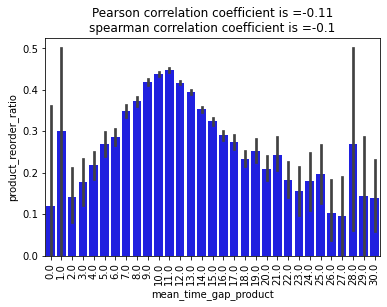

In [88]:
from scipy.stats import spearmanr
corr_coef=np.corrcoef(mean_time_gap_product, product_reorder_ratio)
sp_coeff=spearmanr(np.round(mean_time_gap_product.tolist(),2), np.round(product_reorder_ratio.tolist(),2))
#plt.scatter(mean_time_gap_product,product_reorder_ratio,color='blue')
sns.barplot(np.round(mean_time_gap_product,0),product_reorder_ratio.round(decimals=2),color='blue')
plt.title('Pearson correlation coefficient is ='+ str(np.round(corr_coef[0,1],2))+"\n"\
         "spearman correlation coefficient is ="+str(np.round(sp_coeff[0],2)))
plt.xlabel('mean_time_gap_product')
plt.ylabel('product_reorder_ratio')
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>Plotted here is the x_axis : mean time gap between ordering and reordering the product(x_axis) vs product reorder ratio(y_axis) </li>
<li>We can see that Pearson's and Spearman's coefficients are -ve but they are not significant</li>
<li>We can predict that for reorder ratio to be higher, time gap between ordering should be less</li>
<li>So if time gap between buying a product is less it gives more probability of reordering</li>
</ul>

#### <font color='red'>Days since prior order vs product</font>

In [137]:
mean_time_gap_product=master_prior.dropna(axis=0).groupby(['product_name'])['days_since_prior_order'].aggregate('mean').reset_index()['days_since_prior_order'].tolist()
product_reorder_ratio=master_prior.dropna(axis=0).groupby(['product_name'])['reordered'].aggregate('mean').reset_index()['reordered'].tolist()

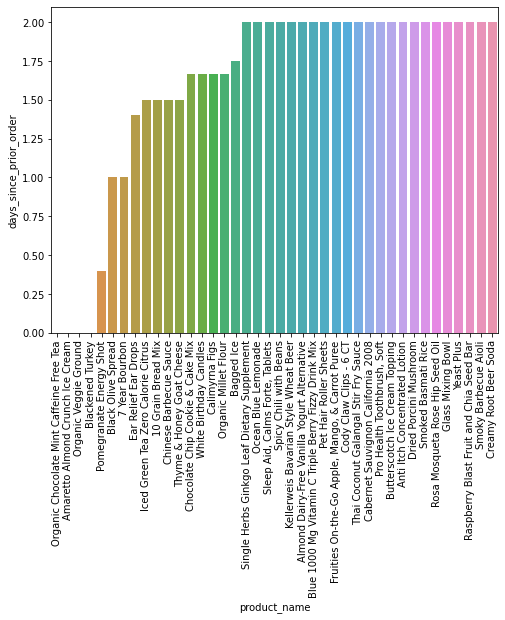

In [156]:
plt.figure(figsize=(8,6))
product_day_gap_relation=master_prior.dropna(axis=0).groupby(['product_name'])['days_since_prior_order'].aggregate('mean').reset_index().sort_values(by=['days_since_prior_order'],ascending=True).head(40)
#product_day_gap_relation=product_day_gap_relation.rename(columns={'reordered':'reordered_ratio'}).head(40)
sns.barplot(product_day_gap_relation.product_name,product_day_gap_relation.days_since_prior_order)
plt.xticks(rotation='vertical')
plt.show()

<ul>
<li>Here x_axis:days_since_prior_order is plotted against y_axis:days_since_prior_order</li>
<li>Some products have lesser days since prior order even as less as 0.24 which indicates they are reordered many times in a single day</li>
<li>It can prove to be a very good feature to determine product reordering</li>
</ul>

#### <font color='red'>Department and count of their occurence</font>

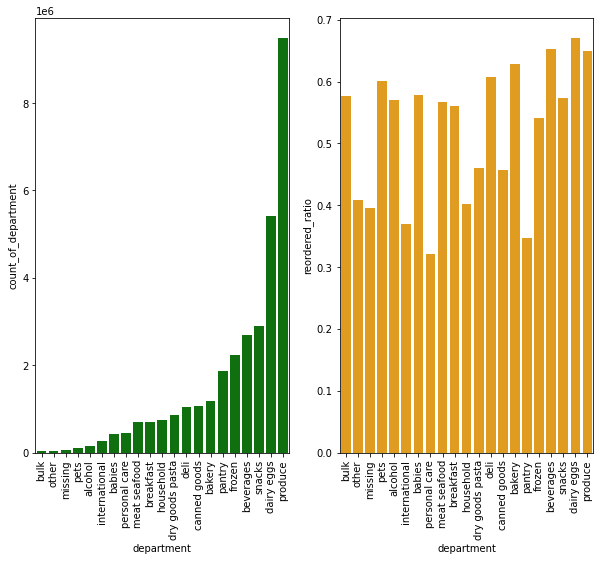

In [130]:
#departments
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
department_freq=master_prior.groupby(['department'])['department_id'].aggregate('count').reset_index().sort_values(by=['department_id'])
department_freq.rename(columns={'department_id':'count_of_department'},inplace=True)
sns.barplot(department_freq.department,department_freq.count_of_department,color='green')
#plt.pie(department_freq['count_of_department'], labels=department_freq['department'],autopct='%1.1f%%')
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
department_reorder_ratio=master_prior.groupby(['department'])['reordered'].aggregate('mean').reset_index().sort_values(by=['reordered'],ascending=False)
department_reorder_ratio=department_reorder_ratio.loc[department_freq.index].rename(columns={'reordered':'reordered_ratio'})
sns.barplot(department_reorder_ratio.department,department_reorder_ratio.reordered_ratio,color='orange')
plt.xticks(rotation='vertical')
plt.show()



<ul>
<li>This is a pie chart of departements with their occurence percentage</li>
<li>Some departments may have daily necessities stored. ex:dairy eggs and produce</li>
<li>Many items coming from perticular departments will have higher reorder ratio</li>
<li>adding department and their percenta share is a good idea </li>
</ul>

#### <font color='red'>Department and reorder ratio</font>

<ul>
<li>plotted x_axis:department name,against y_axis:reorder ratio</li>
<li>Some departments may have daily necessities stored. ex:dairy eggs and produce</li>
<li>Many items coming from perticular departments will have higher reorder ratio</li>
<li>adding department and their reorder ratio as a feature is a good idea </li>
</ul>

#### <font color='red'>Aisle</font>

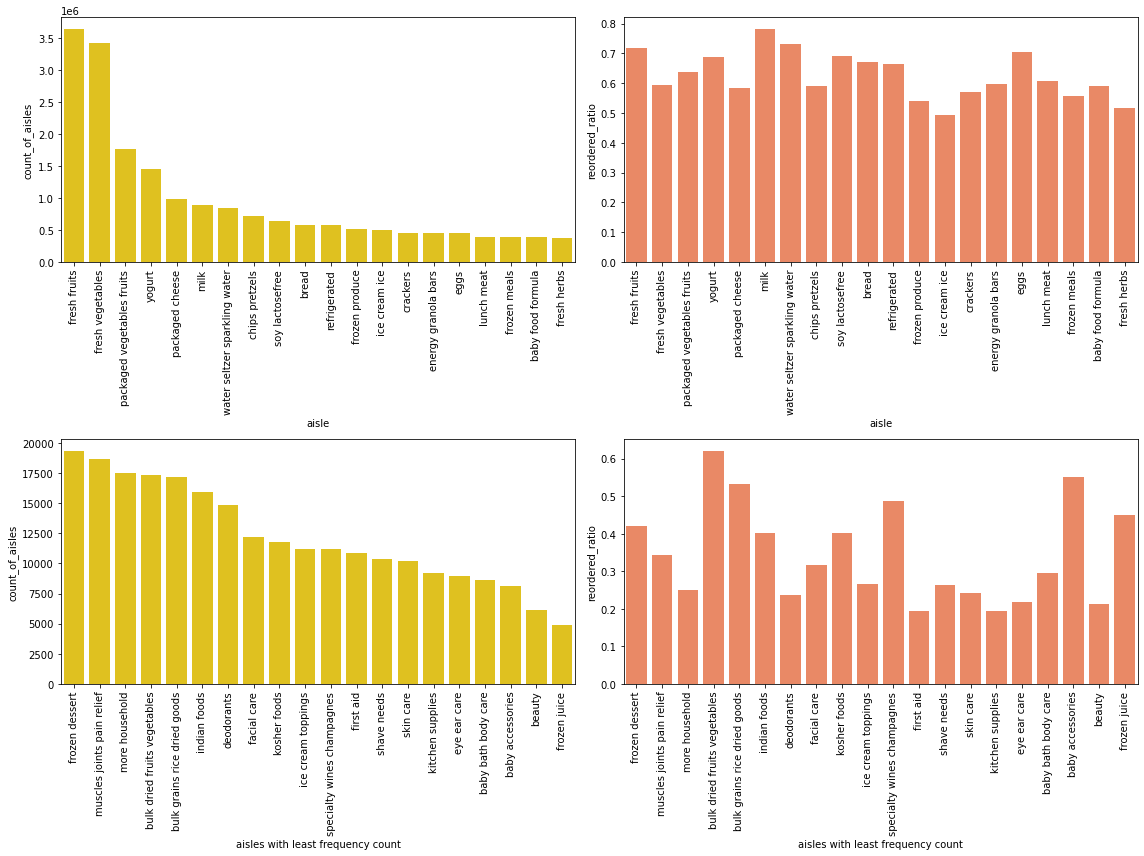

In [132]:
plt.figure(figsize=(16,12))

plt.subplot(2, 2, 1)
aisle_freq_count=master_prior.groupby(['aisle'])['aisle_id'].aggregate('count').reset_index().sort_values(by=['aisle_id'],ascending=False)
aisle_freq__count_mod=aisle_freq_count.rename(columns={'aisle_id':'count_of_aisles'}).head(20)
sns.barplot(aisle_freq__count_mod.aisle,aisle_freq__count_mod.count_of_aisles,color='gold')
plt.xticks(rotation='vertical')


plt.subplot(2, 2, 2)
aisle_reorder_ratio=master_prior.groupby(['aisle'])['reordered'].aggregate('mean').reset_index().sort_values(by=['reordered'],ascending=False)
aisle_reorder_ratio_mod=aisle_reorder_ratio.loc[aisle_freq_count.index].rename(columns={'reordered':'reordered_ratio'}).head(20)
sns.barplot(aisle_reorder_ratio_mod.aisle,aisle_reorder_ratio_mod.reordered_ratio,color='coral')
plt.xticks(rotation='vertical')


plt.subplot(2, 2, 3)
aisle_freq_count=master_prior.groupby(['aisle'])['aisle_id'].aggregate('count').reset_index().sort_values(by=['aisle_id'],ascending=False)
aisle_freq_count_mod=aisle_freq_count.rename(columns={'aisle_id':'count_of_aisles'}).tail(20)
sns.barplot(aisle_freq_count_mod.aisle,aisle_freq_count_mod.count_of_aisles,color='gold')
plt.xlabel('aisles with least frequency count')
plt.xticks(rotation='vertical')


plt.subplot(2, 2, 4)
aisle_reorder_ratio=master_prior.groupby(['aisle'])['reordered'].aggregate('mean').reset_index().sort_values(by=['reordered'],ascending=False)
aisle_reorder_ratio_mod=aisle_reorder_ratio.loc[aisle_freq_count.index].rename(columns={'reordered':'reordered_ratio'}).tail(20)
sns.barplot(aisle_reorder_ratio_mod.aisle,aisle_reorder_ratio_mod.reordered_ratio,color='coral')
plt.xlabel('aisles with least frequency count')
plt.xticks(rotation='vertical')
plt.tight_layout()


#### <font color='red'>Aisle count</font>

<ul>
<li>plotted x_axis:aisle_name against y_axis:count of aisle occurence</li>
<li>Some aisles may have daily necessities stored. ex:fresh fruits and milk</li>
<li>Many items coming from perticular aisle will have higher reorder probability</li>
<li>adding aisle and their count of occurence as a feature is a good idea </li>
</ul>

#### <font color='red'>Aisle reorder ratio</font>

<ul>
<li>plotted x_axis:aisle name against y_axis:reorder ratio</li>
<li>Some aisles may have daily necessities stored. ex:milk and fresh fruits</li>
<li>Many items coming from perticular aisle will have higher reorder ratio</li>
<li>adding aisle and their reorder ratio as a feature is a good idea </li>
</ul>

###  <font color='orange'>Brief summary of the explorator analysis</font>

Briefing here are the important exploratory data analysis made

<ol>
<li>Plotted the reorder probabilities with respect to department ,aisle ,product, add_to_cart,order_hour, order_dow .Department,aisle,product,add_to_cart analysis showed good variation and may be more helpful in our prediction of wheather a product is ordered or not</li>
<li>Plotted reorder ratios of the product with respect to department,aisle,product, add_to_cart,order_hour,order_dow;</li>
<li>Reordered ratios showed good variation for department ,aisle,product,add_to_cart . For order_hour and order_dow they did not have good variation,but when done for each product seperately they looked to have good variation. So when we use this feature along with other feature,they should be helpful</li>
<li>Plotted the total oder count of department ,aisle,product and order count on different days of the week;products which are ordered should be reordered frequentyly,otherwise their count cannot increase</li>
<li>From the products number of occurenes, 0% greek strained yogurt is ordered much more frequently on Thursday and Friday(ie previous two days to the weekend) So order day of week should be an important feature</li>
<li>From reorder ratio with respect to monthly and weekly buyers it is found that number of product which are more often reordered monthly. So days since prior order should be an important variable in our analysis.</li>
<li>Reorder_count to first time order ratio is much more for weekly buyers . Weekly buyers reorders are more. Monthly buyers first time orders are more</li>
<li>For each user reorder ratio is plotted , Each individual type has different reorder ratio and pattern. So userwise reorder ratio and pattern is also important</li>
    
<li>Probability of reorder and reorder ratio both were high for products added early in the cart . This is found out from add_cart_order_number variable</li>
    <li>From Spearman's correlation coefficient analysis it is found that product occreances and their reorder ratio are directly related. So product frequency  can help to analyse if a product will be reordered or not.</li>
</ol>

## citation 
kaggle competetion url:https://www.kaggle.com/c/instacart-market-basket-analysis/<br>
seaborn:https://seaborn.pydata.org/generated/seaborn.barplot.html <br>
pandas:https://pandas.pydata.org/pandas-docs/ <br>
numpy:https://numpy.org/
